In this problem, you will train a neural network to classify satellite images. In the data/EuroSAT_RGB directory, you will find 11 subdirectories, each corresponding to a different class of land or land use: e.g. industrial, crops, rivers, forest, etc. Within each subdirectory, you will find examples in .jpg format of each type. (Thus the name of the directory in which the image lives is the class label.)

Your job is to set up a neural network that can classify the images as accurately as possible. Use an 80/20 train test split. Summarize your model and its accuracy in any way you see fit, but make you include at a minimum the following elements:

overall test-set accuracy, measured however you think is appropriate
show some of the example images from the test set, together with your model's predicted classes.
a confusion matrix showing the performance of the model on the set test, i.e. a table that cross-tabulates each test set example by (actual class, predicted class).

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import tqdm
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns


In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create an instance of the ImageFolder dataset
dataset = ImageFolder(root=r'C:\Users\awaly\Downloads\Python Notebooks\Introduction to Machine Learning\ML Project 2\EuroSAT_RGB', transform=transform)

# Create a DataLoader
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

We set up image data for our machine learning exercise by applying tensor conversion and pixel normalization transformations. We load the transformed images from a directory using ImageFolder, then create a DataLoader to manage batches of these images for training with shuffling and parallel loading. We will send images in batches of 32.

In [3]:
# Access the first image from the dataset
sample_image, _ = dataset[0]

# Get the image size (height, width)
image_size = sample_image.shape[1:]  # Assuming channel dimension is excluded
print("Image Size:", image_size)

Image Size: torch.Size([64, 64])


We want to access the first image from the dataset and retriev its dimensions so we can build our CNN model framework. The image's size, excluding the channel dimension, is 64x64.

In [4]:
# Split dataset indices into train and test sets
dataset_size = len(dataset)
indices = list(range(dataset_size))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)  # Adjust test_size as needed

# Create Subset instances for train and test
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Create DataLoader instances for train and test
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

We split our dataset into training and testing sets by generating indices (70% for training and 30% for testing.). We then create Subset instances for each set and DataLoader instances to efficiently manage batches of data during training and testing. We also shuffled the data for training while maintaining order for testing

In [5]:
# Define a CNNClassifier class that inherits from nn.Module
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()

        # First convolutional layer with 3 input channels, 16 output channels, and a 3x3 kernel
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        # Second convolutional layer with 16 input channels, 32 output channels, and a 3x3 kernel
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)  # Fully connected layer with input size 32*16*16 and output size 128
        self.fc2 = nn.Linear(128, num_classes)  # Fully connected layer with input size 128 and output size num_classes

    # Forward pass function
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Apply convolution, ReLU activation, and pooling
        x = self.pool(F.relu(self.conv2(x)))  # Apply convolution, ReLU activation, and pooling
        x = x.view(-1, 32 * 16 * 16)  # Reshape the tensor to match the fully connected layer's input size
        x = F.relu(self.fc1(x))  # Apply ReLU activation to the first fully connected layer
        x = self.fc2(x)  # Output of the model
        return x

# Determine the number of classes in the dataset
num_classes = len(train_dataset.dataset.classes)  # Access classes from the original dataset
# Create an instance of the CNNClassifier model
model = CNNClassifier(num_classes)


This defines a CNNClassifier class inheriting from nn.Module, which implements a convolutional neural network for image classification. It consists of two convolutional layers, followed by max-pooling, and two fully connected layers. The forward method defines the flow of data through these layers, including activation functions. The number of output classes is determined based on the training dataset's class labels.

In [6]:
import torch.optim as optim

# Determine the device to use for training (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model's parameters to the selected device

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer: Adam optimizer with a learning rate of 0.001, optimizing model parameters
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of training epochs
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the selected device
        optimizer.zero_grad()  # Clear previously computed gradients
        outputs = model(inputs)  # Forward pass: compute model predictions
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backpropagation: compute gradients
        optimizer.step()  # Update model parameters based on gradients

    # Print the loss for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item():.4f}")


Epoch [1/10] - Loss: 0.7554
Epoch [2/10] - Loss: 0.7310
Epoch [3/10] - Loss: 0.7988
Epoch [4/10] - Loss: 0.4786
Epoch [5/10] - Loss: 0.2900
Epoch [6/10] - Loss: 0.4021
Epoch [7/10] - Loss: 0.2180
Epoch [8/10] - Loss: 0.3403
Epoch [9/10] - Loss: 0.1299
Epoch [10/10] - Loss: 0.0829


This configures the training device based on availability (we have a GPU device avaiable), defines the loss function (CrossEntropyLoss), and sets up the optimizer (Adam) with a specified learning rate(0.001). The training loop executes for a set number of epochs(10), where the model is trained on batches of data. Gradients are computed through backpropagation, and the optimizer updates the model's parameters. The loss for each epoch is printed, allowing for monitoring of training progression

We achieved a Loss of 0.0829 after 10 epochs after starting from a loss of 0.7554 in the first epoch

In [10]:
# Set the model to evaluation mode (no gradient computation)
model.eval()

# Lists to store test labels and predictions
test_labels = []
test_preds = []

# Disable gradient calculation for inference
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the selected device
        outputs = model(inputs)  # Forward pass: compute model predictions
        _, preds = torch.max(outputs, 1)  # Get predicted class indices
        test_labels.extend(labels.cpu().numpy())  # Convert labels to NumPy array and extend the list
        test_preds.extend(preds.cpu().numpy())  # Convert predictions to NumPy array and extend the list

# Calculate test accuracy using scikit-learn's accuracy_score function
test_accuracy = accuracy_score(test_labels, test_preds)

# Print test accuracy and confusion matrix
print(f"Test Accuracy: {test_accuracy:.2%}")


Test Accuracy: 85.30%


We achieved a Test Dataset Accuracy of 85.30% which is pretty impressive considering the fact we did not use a pre-trained model and built our own from scratch.

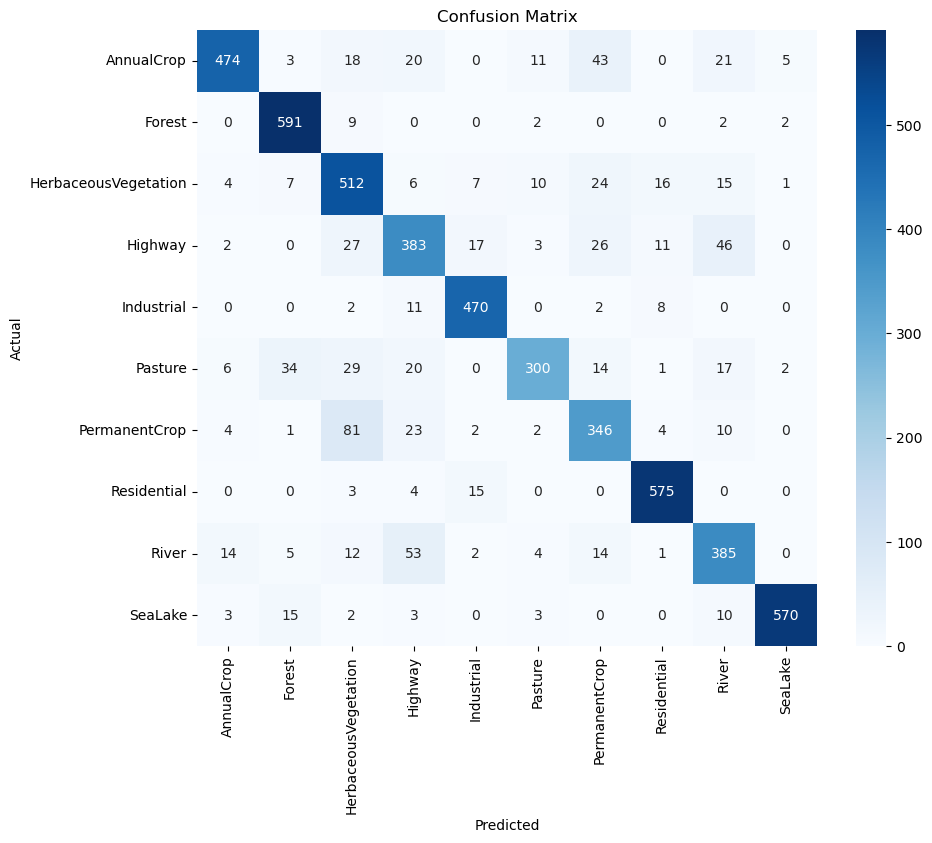

In [13]:
# Compute the confusion matrix using scikit-learn's confusion_matrix function
conf_matrix = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.dataset.classes, yticklabels=test_dataset.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

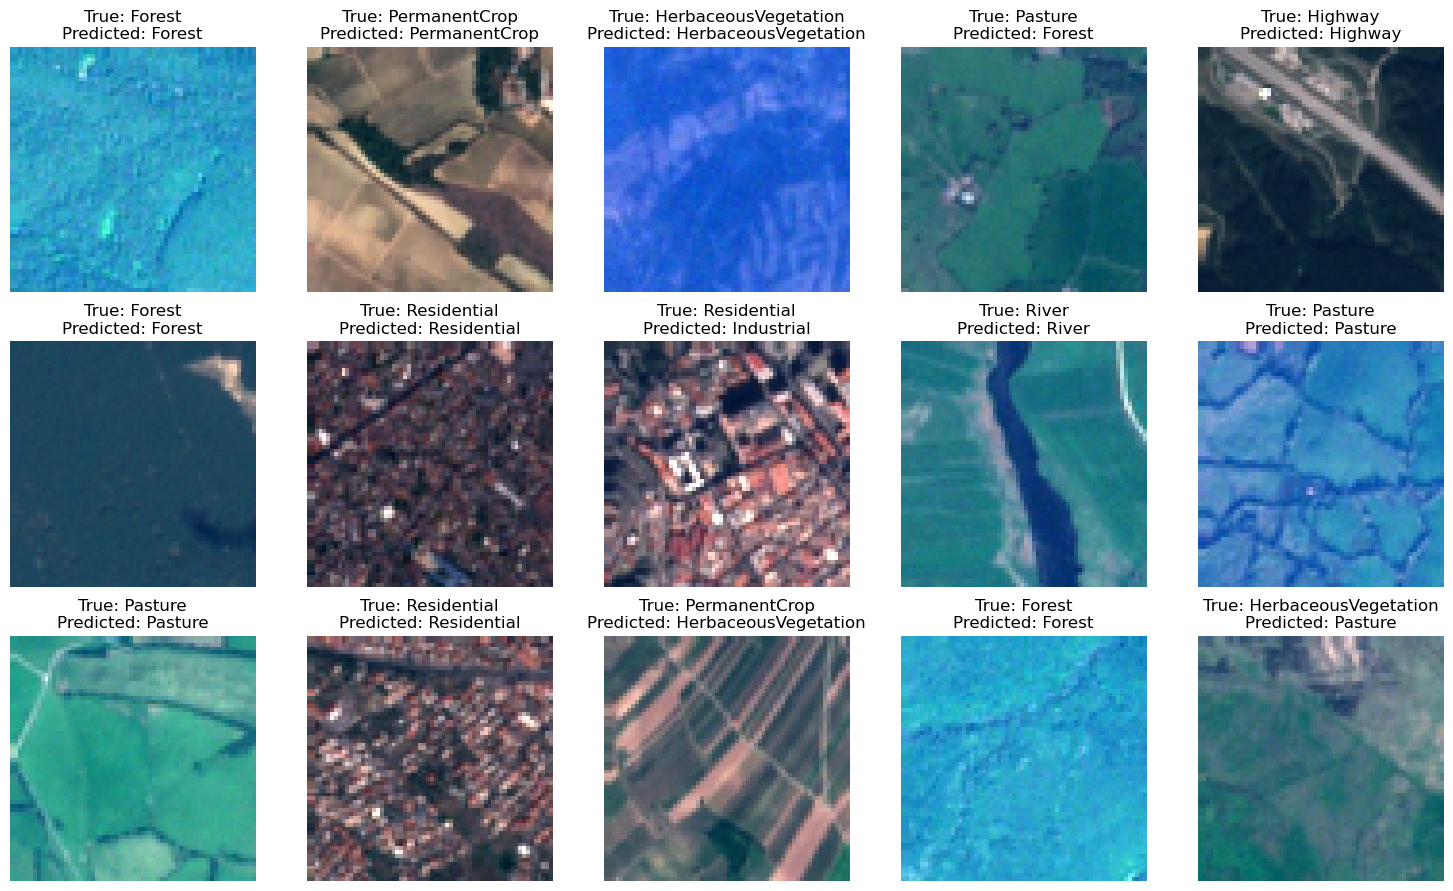

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Get a batch of test images and their labels
images, labels = next(iter(test_loader))

# Move images to the selected device
images = images.to(device)

# Make predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)  # Get predicted class indices

# Convert labels and predictions to numpy arrays
label_names = np.array(train_dataset.dataset.classes)  # Access classes from the original dataset
true_labels = labels.numpy()
predicted_labels = predicted.cpu().numpy()

# Display example images with their true and predicted classes
num_rows = 3
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 9))

for row in range(num_rows):
    for col in range(num_cols):
        index = row * num_cols + col
        image = images[index].cpu().numpy().transpose((1, 2, 0))  # Convert image tensor to NumPy array
        
        # Normalize the image to the [0, 1] range
        image = (image - image.min()) / (image.max() - image.min())
        
        true_class = label_names[true_labels[index]]  # Get the true class label
        predicted_class = label_names[predicted_labels[index]]  # Get the predicted class label
        
        axes[row, col].imshow(image)  # Display the image
        axes[row, col].set_title(f"True: {true_class}\nPredicted: {predicted_class}")  # Set title with labels
        axes[row, col].axis('off')  # Turn off axis for cleaner display

plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Show the plot


We want to visualize how our model is classifying images so we test our CNN model on a sample of test dataset images. Our portray our predictions, a grid of images is exhibited, complete with true and predicted labels in their titles. The images are normalized for clarity, effectively illustrating the model's proficiency in classifying the test data